In [17]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC



In [18]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

### Custom pipeline for dat pre-processing

In [19]:
from imblearn.over_sampling import SMOTE
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = 'Binary', smote = False):
        self.label_encode = label_encode
        self.process_label = process_label
        self.smote = smote
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state', 'attack_cat']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label == 'Binary':
            df.drop('attack_cat', axis=1, inplace=True)
        else:             
            df['attack_cat'], df['label'] = df['label'], df['attack_cat']
            df.drop('attack_cat', axis=1, inplace=True)   

        if self.smote:
            # Separate features and labels
            X = df.drop('label', axis=1)
            y = df['label']

            # Apply SMOTE for oversampling
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X, y)

            # Convert NumPy arrays back to Pandas DataFrames
            X_resampled_df = pd.DataFrame(data=X_resampled, columns=X.columns)
            y_resampled_df = pd.DataFrame(data=y_resampled, columns=['label'])

            # Concatenate the features and label columns into a single DataFrame
            df = pd.concat([X_resampled_df, y_resampled_df], axis=1)   

        return df

In [20]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [21]:
pipeline_train = PreProcessPipeline(label_encode=True, process_label='Binary')
pipeline_test = PreProcessPipeline(label_encode=True, process_label='Binary')
train_df = pipeline_train.transform(train_df)
test_df = pipeline_test.transform(test_df)

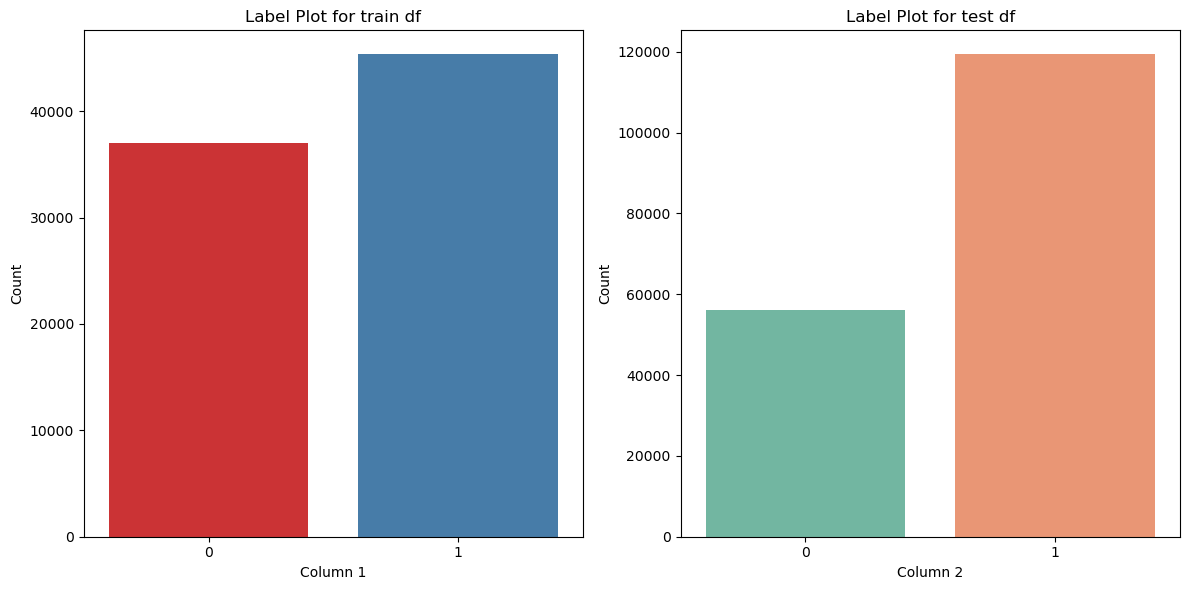

In [22]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot countplot for column1
sns.countplot(data=train_df, x='label', palette="Set1", ax=axes[0])
axes[0].set_title("Label Plot for train df")
axes[0].set_xlabel("Column 1")
axes[0].set_ylabel("Count")

# Plot countplot for column2
sns.countplot(data=test_df, x='label', palette="Set2", ax=axes[1])
axes[1].set_title("Label Plot for test df")
axes[1].set_xlabel("Column 2")
axes[1].set_ylabel("Count")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [23]:
combined_df = pd.concat([train_df, test_df])
shuffled_df = combined_df.sample(frac=1, random_state=42)
split_ratio = 0.8
split_index = int(len(shuffled_df) * split_ratio)

train_df = shuffled_df[:split_index]
test_df = shuffled_df[split_index:]

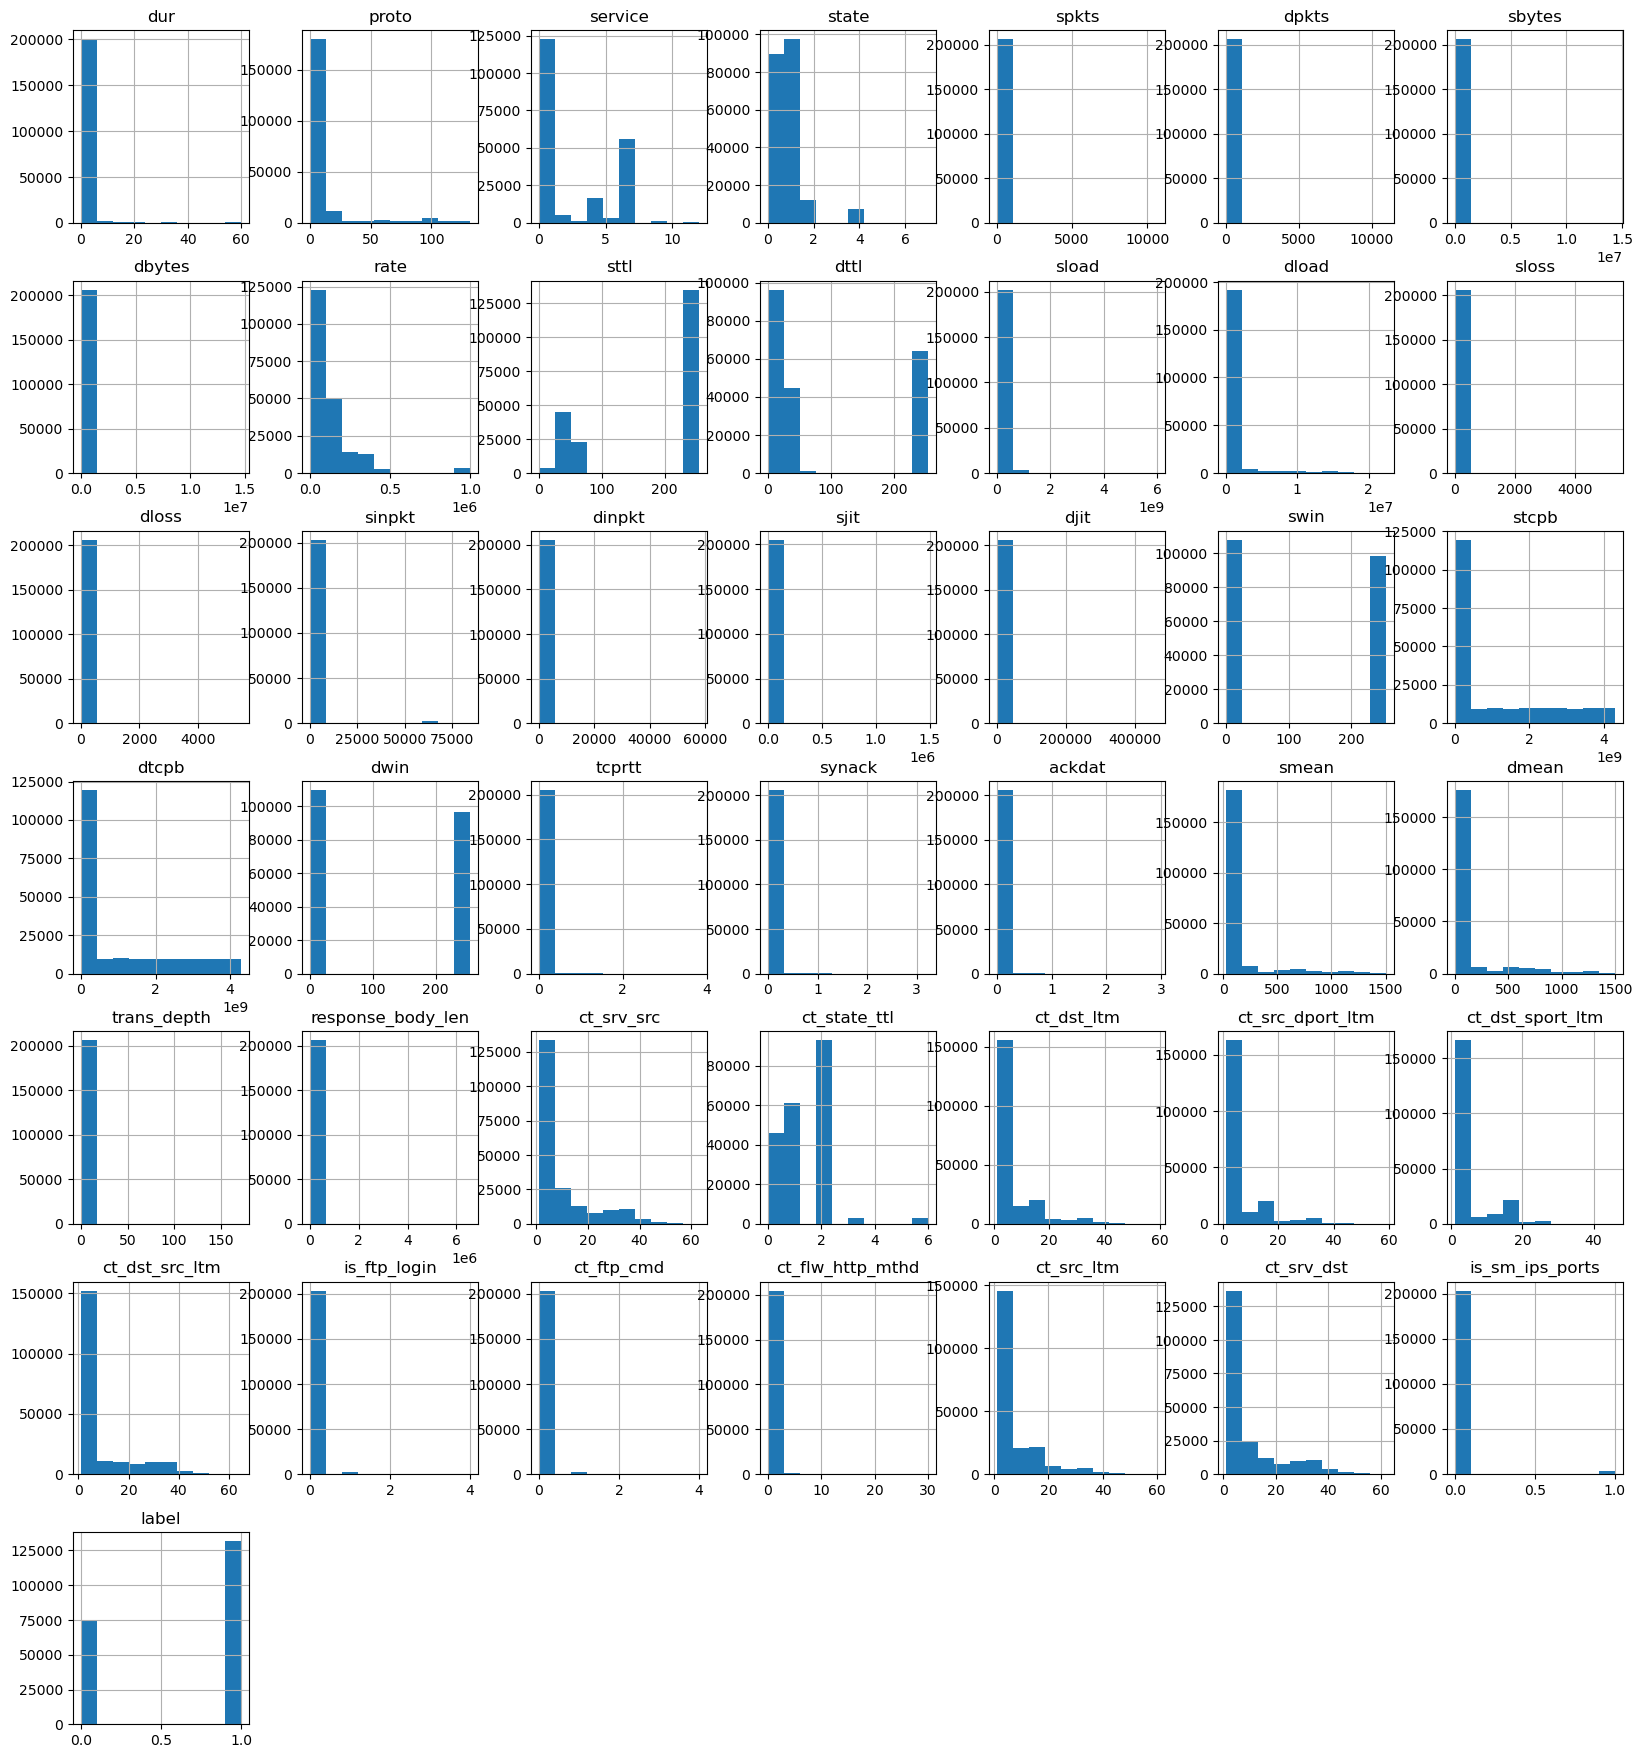

In [24]:
rcParams["figure.figsize"]=(20,22)
train_df.hist()
plt.grid()

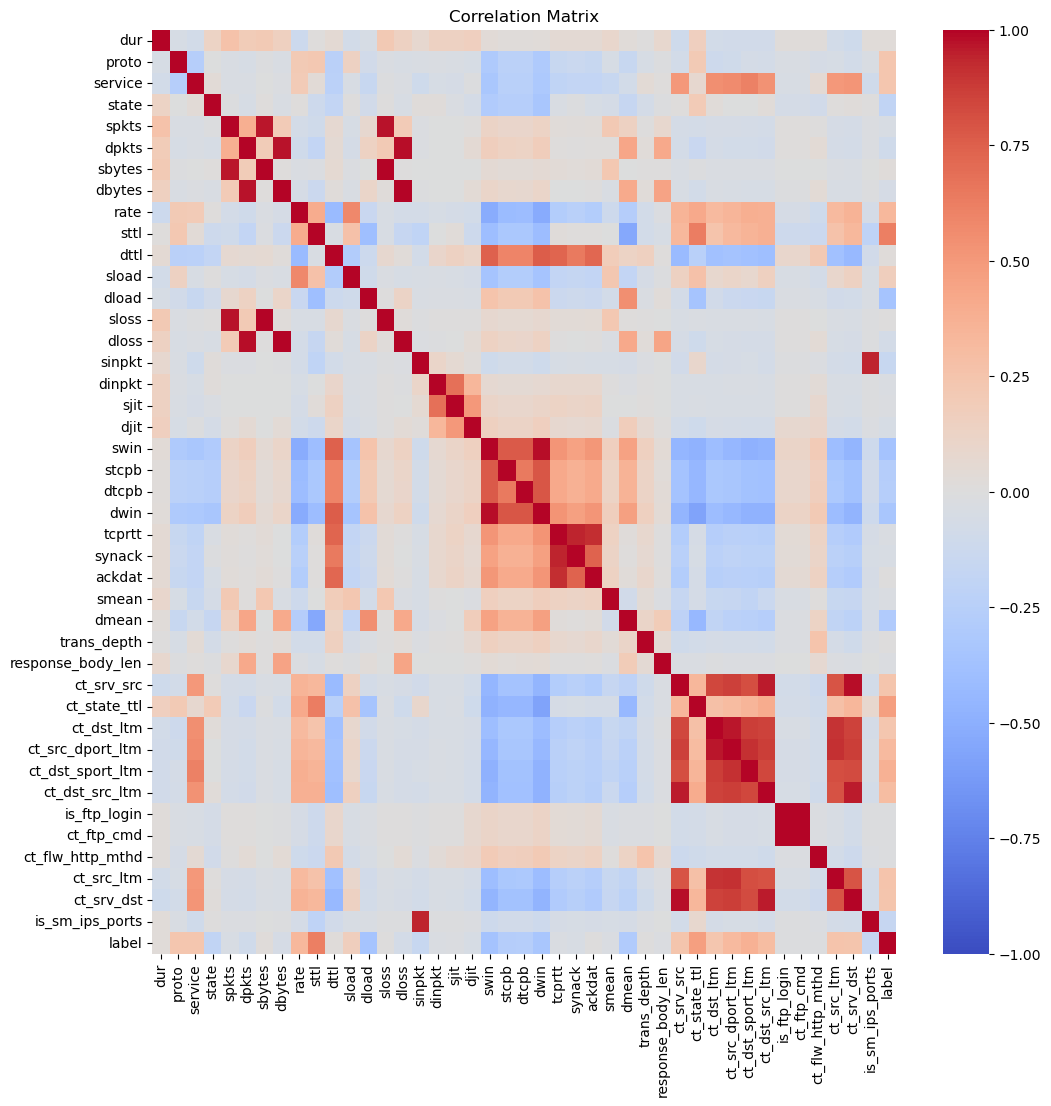

In [25]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = train_df.corr()

# Select the correlation values with 'label', label here means attack_cat
target_corr = corr_matrix['label']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

In [26]:
# Show the feature ranking in corr order 

# Calculate the absolute correlation values with the 'label'
target_corr_abs = corr_matrix['label'].abs()

# Sort the correlation values in descending order
sorted_corr = target_corr_abs.sort_values(ascending=False)

# Print the sorted correlation values and their corresponding attributes
for attribute, correlation in target_corr_abs.items():
    print(f"{attribute}: {correlation:.4f}")

dur: 0.0305
proto: 0.2346
service: 0.2397
state: 0.1926
spkts: 0.0405
dpkts: 0.0976
sbytes: 0.0201
dbytes: 0.0607
rate: 0.3345
sttl: 0.6239
dttl: 0.0194
sload: 0.1643
dload: 0.3525
sloss: 0.0030
dloss: 0.0764
sinpkt: 0.1549
dinpkt: 0.0303
sjit: 0.0163
djit: 0.0503
swin: 0.3645
stcpb: 0.2660
dtcpb: 0.2644
dwin: 0.3385
tcprtt: 0.0248
synack: 0.0435
ackdat: 0.0008
smean: 0.0273
dmean: 0.2957
trans_depth: 0.0018
response_body_len: 0.0184
ct_srv_src: 0.2454
ct_state_ttl: 0.4744
ct_dst_ltm: 0.2405
ct_src_dport_ltm: 0.3178
ct_dst_sport_ltm: 0.3712
ct_dst_src_ltm: 0.2987
is_ftp_login: 0.0082
ct_ftp_cmd: 0.0085
ct_flw_http_mthd: 0.0119
ct_src_ltm: 0.2517
ct_srv_dst: 0.2474
is_sm_ips_ports: 0.1594
label: 1.0000


In [27]:
spark = SparkSession.builder.appName("CSCI316GP2").getOrCreate()

In [28]:
sparktrain_df = spark.createDataFrame(train_df)
sparktest_df = spark.createDataFrame(test_df)

In [29]:
'''
Author: Khanh Nguyen
Name: PySpark Dataframe Pipeline
Description:
    This class is used to create a pipeline for PySpark dataframe, accept 2 boolean parameter: smote & standardize.
    Features 
        (Default)
        - Resample: Resample the dataframe
        - Vectorize: Vectorize the dataframe
        (activate by setting the parameter to True):
        - SMOTE: Oversampling the minority class
        - Standardize: Standardize the dataframe using z-score
'''

from pyspark.sql.functions import col
class SparkDFPipeline:
    def __init__(self, standardize=False):
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):      
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]
            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            train_df = train_df.select('features', 'label')
            test_df = assembler.transform(test_df)
              
        return train_df, test_df

In [30]:

pipeline = SparkDFPipeline(standardize=True)
train, test = pipeline.transform(sparktrain_df, sparktest_df)

23/08/15 17:18:02 WARN TaskSetManager: Stage 14 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:18:08 WARN TaskSetManager: Stage 20 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


In [31]:
train.show()

23/08/15 17:18:09 WARN TaskSetManager: Stage 23 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+
|            features|label|
+--------------------+-----+
|[-0.0802591004089...|    0|
|[-0.2093226086617...|    1|
|[-0.2093219443096...|    1|
|[-0.2054690345482...|    0|
|[-0.2093224425737...|    1|
|[-0.2093224425737...|    1|
|[-0.2093224425737...|    1|
|[-0.2093224425737...|    1|
|[-0.2093226086617...|    1|
|[-0.0907995440758...|    0|
|[-0.2093224425737...|    1|
|[-0.1226379521116...|    1|
|[-0.2091535310629...|    0|
|[-0.2093234391017...|    1|
|[-0.2093226086617...|    1|
|[-0.2093239373658...|    0|
|[-0.1222529600939...|    0|
|[-0.2093222764856...|    0|
|[-0.1140321016381...|    0|
|[-0.2086099249913...|    0|
+--------------------+-----+
only showing top 20 rows



## SVM Model

In [32]:
# Train an SVM model
svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=100) 
svm_model = svm.fit(train)

23/08/15 17:18:10 WARN TaskSetManager: Stage 26 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:18:12 WARN TaskSetManager: Stage 27 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:18:20 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/15 17:21:38 WARN TaskSetManager: Stage 781 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 17:21:41 WARN TaskSetManager: Stage 782 contains a task of very large size (4286 KiB). The maximum recommended task size is 1000 KiB.


In [33]:
# Make prediction 

predictions = svm_model.transform(test)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

# Create an evaluator for accuracy
roc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_score = roc_evaluator.evaluate(predictions)
print("Area under ROC = %g" % roc_score)

# Create an evaluator for f1 score
pr_evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderPR")
pr_score = pr_evaluator.evaluate(predictions)
print("Area under PR = %g" % pr_score)

23/08/15 17:21:43 WARN TaskSetManager: Stage 783 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 0.9090715048025614


23/08/15 17:21:44 WARN TaskSetManager: Stage 785 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


Area under ROC = 0.883154


23/08/15 17:21:47 WARN TaskSetManager: Stage 796 contains a task of very large size (1034 KiB). The maximum recommended task size is 1000 KiB.


Area under PR = 0.888098


### Fine tune SVM Model

In [34]:
'''

from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=100)

# Define the parameter grid for tuning
param_grid = ParamGridBuilder() \
    .addGrid(svm.tol, [1e-5, 1e-6, 1e-7]) \
    .build()

# Define the evaluator for model selection
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")

# Create CrossValidator
cross_val = CrossValidator(estimator=svm,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=5)  # Number of folds for cross-validation

# Fit CrossValidator on train data
cv_model = cross_val.fit(train)

# Get the best LinearSVC model from the cross-validation
best_svm_model = cv_model.bestModel

'''

'\n\nfrom pyspark.ml.classification import LinearSVC\nfrom pyspark.ml.tuning import ParamGridBuilder, CrossValidator\nfrom pyspark.ml.evaluation import BinaryClassificationEvaluator\n\nsvm = LinearSVC(featuresCol="features", labelCol="label", maxIter=100)\n\n# Define the parameter grid for tuning\nparam_grid = ParamGridBuilder()     .addGrid(svm.tol, [1e-5, 1e-6, 1e-7])     .build()\n\n# Define the evaluator for model selection\nevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")\n\n# Create CrossValidator\ncross_val = CrossValidator(estimator=svm,\n                           estimatorParamMaps=param_grid,\n                           evaluator=evaluator,\n                           numFolds=5)  # Number of folds for cross-validation\n\n# Fit CrossValidator on train data\ncv_model = cross_val.fit(train)\n\n# Get the best LinearSVC model from the cross-validation\nbest_svm_model = cv_model.bestModel\n\n'

In [ ]:
# Make prediction 

predictions = best_svm_model.transform(test)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

# Create an evaluator for accuracy
roc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_score = roc_evaluator.evaluate(predictions)
print("Area under ROC = %g" % roc_score)

# Create an evaluator for f1 score
pr_evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="prediction", metricName="areaUnderPR")
pr_score = pr_evaluator.evaluate(predictions)
print("Area under PR = %g" % pr_score)

In [ ]:
spark.stop()